# Digit Classifier
Using MNIST datasets from http://yann.lecun.com/exdb/mnist/

In [10]:
# importing stuff
import numpy as np
import matplotlib.pyplot as plt # to plot the cost
import struct # to read the datasets

In [11]:
def rev_one_hot(a):
    # function to reverse the 'one hot' created
    b = np.zeros((1,a.shape[1]))
    for i in range(a.shape[1]):
        for j in range(a.shape[0]):
            if(a[j,i] == 1):
                b[0,i] = j
                break
    return b

In [12]:
def initializer(layers_info,X):
    # initializing parameters
    parameters = {}
    layers_info.insert(0,X.shape[0])
    for i in range(1,len(layers_info)):
        parameters['W'+str(i)] = np.random.randn(layers_info[i],layers_info[i-1]) * 0.01
        parameters['b'+str(i)] = np.zeros((layers_info[i],1))
    return parameters,layers_info

In [13]:
def forward_prop(parameters,X,layers_info):
    # implementing forward propagation
    logits = {}
    activations = {}
    activations['A0'] = X
    for i in range(1,len(layers_info)-1):
        logits['Z'+str(i)] = np.dot(parameters['W'+str(i)],activations['A'+str(i-1)]) + parameters['b'+str(i)]
        activations['A'+str(i)] = tanh(logits['Z'+str(i)])
        
    logits['Z'+str(len(layers_info)-1)] = np.dot(parameters['W'+str(len(layers_info)-1)],activations['A'+str(len(layers_info)-1-1)]) + parameters['b'+str(len(layers_info)-1)]
    activations['A'+str(len(layers_info)-1)] = np.exp(logits['Z'+str(len(layers_info)-1)])/np.sum(np.exp(logits['Z'+str(len(layers_info)-1)]),axis=0,keepdims=True)
    
    return logits,activations

In [14]:
def compute_cost(activations,Y,layers_info):
    # calculating cost
    AL = activations['A'+str(len(layers_info)-1)]
    cost = (-1/Y.shape[1])*np.sum(Y*np.log(AL))
    return cost

In [15]:
def back_prop(X,Y,parameters,activations,layers_info,logits):
    # implementing backward propagation
    gradients = {}
    m = Y.shape[1]
    gradients['dZ'+str(len(layers_info)-1)] = activations['A'+str(len(layers_info)-1)] - Y
    gradients['dW'+str(len(layers_info)-1)] = (1/m) * np.dot(gradients['dZ'+str(len(layers_info)-1)],activations['A'+str(len(layers_info)-2)].T)
    gradients['db'+str(len(layers_info)-1)] = (1/m) * np.sum(gradients['dZ'+str(len(layers_info)-1)],axis=1,keepdims=True)
    for i in range(2,len(layers_info)):
        gradients['dZ'+str(len(layers_info) - i)] = np.dot(parameters['W'+str(len(layers_info)-i+1)].T,gradients['dZ'+str(len(layers_info)-i+1)])*(1-np.square(tanh(logits['Z'+str(len(layers_info)-i)])))
        gradients['dW'+str(len(layers_info)-i)] = (1/m) * np.dot(gradients['dZ'+str(len(layers_info)-i)],activations['A'+str(len(layers_info)-i-1)].T)
        gradients['db'+str(len(layers_info)-i)] = (1/m) * np.sum(gradients['dZ'+str(len(layers_info)-i)],axis=1,keepdims=True)
    return gradients

In [16]:
def start_training(X,Y,layers_info,max_iter,learning_rate=0.01):
    # Main loop to start training
    
    parameters,layers_info = initializer(layers_info,X)
    
    global costs # this is global so plot can be made even outside the function
    costs = []
    
    for j in range(max_iter):
        logits,activations = forward_prop(parameters,X,layers_info)
        #for j in logits.keys():
        #    print(j)
        cost = compute_cost(activations,Y,layers_info)
        costs.append(cost)
        gradients = back_prop(X,Y,parameters,activations,layers_info,logits)
        for i in range(1,len(layers_info)):
            parameters['W'+str(i)] -= learning_rate*gradients['dW'+str(i)]
            parameters['b'+str(i)] -= learning_rate*gradients['db'+str(i)]
            
        if(j%100 == 0):
            print(cost)
            
    plt.plot(costs)
    #plt.ylim(0,5)
    plt.ylabel('Cost')
    plt.xlabel('Num Iterations')
    return parameters

In [17]:
# opening and manipulating the Dataset

with open('datasets/Hdigits_train.idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    data = data.reshape((size, nrows, ncols))
X = data
with open('datasets/Hdigits_train_labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
Y_raw = data
X = X/255
X = X.reshape(X.shape[0],-1)
X = X.T
Y_raw = Y_raw.reshape(1,60000)
Y_hot = np.zeros((10,60000))
for i in range(60000):             #one hotting the labels
    Y_hot[Y_raw[0,i],i] = 1
Y = Y_hot

2.3002930915178736
1.5490620179468133
1.1902854356732897
0.997025574409552
0.8785896957116333
0.7986067321950849
0.7407321187981586
0.6967080511399139
0.6619450832272159
0.6336935286950265


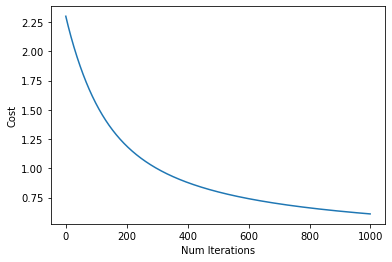

In [18]:
layers_info = [10] # define layers here
trained_parameters = start_training(X,Y,layers_info,1000) # define max_iterations here

In [28]:
_ , activations = forward_prop(trained_parameters,X,layers_info)
A = activations['A'+str(len(layers_info)-1)]
for i in range(60000):
    A[:,i] = (A[:,i] == np.max(A[:,i])).astype(float)
rev_hotted_A = rev_one_hot(A)
predictions = (rev_hotted_A == Y_raw).astype(int)
accuracy = np.sum(predictions)/predictions.shape[1]
print('Train set Accuracy: '+str(accuracy*100)+'%')

Train set Accuracy: 86.095%


In [26]:
# loading and manipulating test dataset

with open('datasets/Hdigits_test.idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    data = data.reshape((size, nrows, ncols))
X_test = data
with open('datasets/Hdigit_test_labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
Y_test = data
X_test = X_test/255
X_test = X_test.reshape(X_test.shape[0],-1)
X_test = X_test.T
Y_test = Y_test.reshape(1,Y_test.shape[0])

In [29]:
_ , activations = forward_prop(trained_parameters,X_test,layers_info)
A = activations['A'+str(len(layers_info)-1)]
for i in range(A.shape[1]):
    A[:,i] = (A[:,i] == np.max(A[:,i])).astype(float)
rev_hotted_A = rev_one_hot(A)
predictions = (rev_hotted_A == Y_test).astype(int)
accuracy = np.sum(predictions)/predictions.shape[1]
print('Test set Accuracy: '+str(accuracy*100)+'%')

Test set Accuracy: 87.06%


## HyperParameter Search 

for  
&nbsp;&nbsp;&nbsp;&nbsp;learning_rate = 0.01  
&nbsp;&nbsp;&nbsp;&nbsp;max_iter = 1000  
&nbsp;&nbsp;&nbsp;&nbsp;layers_info = [10]
   
train accuracy = 86.06%  
test accuracy = 87.12% 

for  
&nbsp;&nbsp;&nbsp;&nbsp;learning_rate = 0.01  
&nbsp;&nbsp;&nbsp;&nbsp;max_iter = 1000  
&nbsp;&nbsp;&nbsp;&nbsp;layers_info = [15,10]
   
train accuracy = 62.89%  
test accuracy = 63.72% 

for  
&nbsp;&nbsp;&nbsp;&nbsp;learning_rate = 0.01  
&nbsp;&nbsp;&nbsp;&nbsp;max_iter = 1000  
&nbsp;&nbsp;&nbsp;&nbsp;layers_info = [30,10]
   
train accuracy = 68.03%  
test accuracy = 68.58% 